<a href="https://colab.research.google.com/github/frontier1020/Korbert_Start/blob/master/bert02_0207_navershopping_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### GPU를 변경해서 해보기
# wget을 활용해서 bert 모델 다운로드 가능
import os
!wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip

if "bert" not in os.listdir():
  os.makedirs("bert")
else:
  pass

import zipfile
import shutil
         
## 경로 지정 후, 풀기 
bert_zip = zipfile.ZipFile('multi_cased_L-12_H-768_A-12.zip')
bert_zip.extractall('bert')
 
bert_zip.close()

def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

copytree("bert/multi_cased_L-12_H-768_A-12", "bert")

--2020-02-07 07:10:04--  https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.128, 2607:f8b0:4001:c1b::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662903077 (632M) [application/zip]
Saving to: ‘multi_cased_L-12_H-768_A-12.zip’

multi_cased_L-12_H- 100%[===================>] 632.19M   130MB/s    in 5.6s    

2020-02-07 07:10:10 (112 MB/s) - ‘multi_cased_L-12_H-768_A-12.zip’ saved [662903077/662903077]



In [2]:
### 구글 드라이브 Colab 연동
import os
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [3]:
### 훈련된 모델 사용
os.listdir('gdrive/My Drive/Colab Notebooks/naver_sentiment')

['bert.h5', 'bert_naver.h5', 'bertembedding.pkl']

In [0]:
path = "gdrive/My Drive/Colab Notebooks/naver_sentiment"

In [5]:
### 모듈 임포트
import tensorflow as tf

import pandas as pd
import numpy as np  
import re
import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers

import codecs
from tqdm import tqdm
import shutil

Using TensorFlow backend.


In [0]:
from keras.utils.np_utils import to_categorical

In [0]:
import warnings
import tensorflow as tf
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.logging.set_verbosity(tf.logging.ERROR)

In [8]:
# Bert 활용. Adam optimizer의 수정판(radam) 모듈 설치 및 임포트
!pip install keras-bert
!pip install keras-radam

  Created wheel for keras-bert: filename=keras_bert-0.81.0-cp36-none-any.whl size=37913 sha256=cad0787dbfe0aef4c941fdc35e971d6d09810754b99c822fb3d0ccd32ac6fc56
  Stored in directory: /root/.cache/pip/wheels/bd/27/da/ffc2d573aa48b87440ec4f98bc7c992e3a2d899edb2d22ef9e
  Created wheel for keras-transformer: filename=keras_transformer-0.32.0-cp36-none-any.whl size=13266 sha256=04e948fdf5ebbd898e16bff0d8b2f4c29681137c6abfc897ef3e483d9f2f5e40
  Stored in directory: /root/.cache/pip/wheels/62/f0/ce/82fa5d024d5ef8e263f26a50dcee23820efe245680ce9c922a
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp36-none-any.whl size=7554 sha256=b8aedd42d9a02359b185ff2b8c6a09c5f2d483646d067d481fc6ff9b4287ceee
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.22.0-cp36-none-any.whl size=15371 sha256=c06328f72e8c11eec29ef545e7093307b026985b286f1610947d4bbe75270a56
  Stor

In [0]:
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

from keras_radam import RAdam

In [10]:
os.listdir('bert')

['bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'bert_model.ckpt.meta',
 'vocab.txt',
 'multi_cased_L-12_H-768_A-12',
 'bert_config.json']

In [11]:
### 네이버 감성분석 데이터 다운로드
!rm -rf nsmc
!git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 18.83 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [12]:
!rm -rf Korbert_Start
!git clone https://github.com/frontier1020/Korbert_Start

Cloning into 'Korbert_Start'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 21 (delta 6), reused 9 (delta 2), pack-reused 0
Unpacking objects: 100% (21/21), done.


In [13]:
!ls -ls Korbert_Start

total 4008
3536 -rw-r--r-- 1 root root 3619294 Feb  7 07:14 bert02_0207_navershopping.ipynb
  80 -rw-r--r-- 1 root root   80409 Feb  7 07:14 korbert_start.ipynb
   4 -rw-r--r-- 1 root root      39 Feb  7 07:14 README.md
 144 -rw-r--r-- 1 root root  146637 Feb  7 07:14 review_1500.csv
  52 -rw-r--r-- 1 root root   49825 Feb  7 07:14 review_500.csv
 192 -rw-r--r-- 1 root root  196435 Feb  7 07:14 review_all.csv


In [14]:
os.listdir('nsmc')

['ratings.txt',
 'ratings_train.txt',
 'code',
 'raw',
 'ratings_test.txt',
 'README.md',
 'synopses.json',
 '.git']

In [0]:
# train = pd.read_table("nsmc/"+"ratings_train.txt")
# test = pd.read_table("nsmc/"+"ratings_test.txt")
train = pd.read_csv("Korbert_Start/"+"review_1500.csv")
test = pd.read_csv("Korbert_Start/"+"review_500.csv")

In [17]:
train.columns

Index(['리뷰', '점수', '감정판단'], dtype='object')

In [0]:
SEQ_LEN = 128
BATCH_SIZE = 16
EPOCHS=2
LR=1e-5

pretrained_path ="bert"
config_path = os.path.join(pretrained_path, 'bert_config.json')     # 어떤 설정이 들어가있을까?
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')  # ckpt는 기존에 학습된 가중치
vocab_path = os.path.join(pretrained_path, 'vocab.txt')  # 토큰화할때 사용하는 단어..

# DATA_COLUMN = "document"
# LABEL_COLUMN = "label"
DATA_COLUMN = "리뷰"
LABEL_COLUMN = "점수"

In [0]:
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        if "_" in token:
          token = token.replace("_","")
          token = "##" + token
        token_dict[token] = len(token_dict)

In [0]:
### inherit_Tokenizer클래스는 문장을 토큰화하는 기능을 한다.
### 한국어할때 꼭 해야 한다. 
class inherit_Tokenizer(Tokenizer):
  def _tokenize(self, text):
        if not self._cased:
            text = text
            text = text.lower()
        spaced = ''
        for ch in text:
            if self._is_punctuation(ch) or self._is_cjk_character(ch):
                spaced += ' ' + ch + ' '
            elif self._is_space(ch):
                spaced += ' '
            elif ord(ch) == 0 or ord(ch) == 0xfffd or self._is_control(ch):
                continue
            else:
                spaced += ch
        tokens = []
        for word in spaced.strip().split():
            tokens += self._word_piece_tokenize(word)
        return tokens

In [0]:
### 구체적으로 무엇을 하는가?
tokenizer = inherit_Tokenizer(token_dict)

In [24]:
tokenizer.tokenize("케라스로 버트 해보기 정말 재밌음.")

['[CLS]',
 '케',
 '##라',
 '##스로',
 '버',
 '##트',
 '해',
 '##보',
 '##기',
 '정',
 '##말',
 '재',
 '##밌',
 '##음',
 '.',
 '[SEP]']

In [0]:
### 네이버 영화 댓글 감성분석 데이터 - 버트 모형에 맞춰 변형해주는 함수
### 함수 내부의 tokenizer.encode가 함수가 버튼 모형을 토큰화 해준다. 
### 토큰화된 단어를 인덱스에 맞게 숫자로 변경.
def convert_data(data_df):
    global tokenizer
    indices, targets = [], []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        indices.append(ids)
        targets.append(data_df[LABEL_COLUMN][i])
    items = list(zip(indices, targets))
    
    indices, targets = zip(*items)
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)], np.array(targets)

def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_x, data_y = convert_data(data_df)

    return data_x, data_y

In [26]:
print(train.shape)
print(train.columns)

(1698, 3)
Index(['리뷰', '점수', '감정판단'], dtype='object')


In [27]:
## 데이터를 학습용 X, y로 나누어준다.
train_x, train_y = load_data(train)
test_x, test_y = load_data(test)
# sel = ['리뷰']
# train_x = train[sel]
# test_x = test[sel]

# train_y = train['감정판단']
# test_y = test['감정판단']

100%|██████████| 562/562 [00:00<00:00, 5414.72it/s]


In [35]:
print(train_y[1:30])

[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


In [0]:
train_y1 = to_categorical(train_y, 6)
test_y1 = to_categorical(test_y, 6)

In [37]:
train_y1

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [0]:
def sentence_convert_data(data):
    global tokenizer
    indices = []
    for i in tqdm(range(len(data))):
        print(tokenizer.tokenize(data[i]))
        ids, segments = tokenizer.encode(data[i], max_len=SEQ_LEN)
        indices.append(ids)
        
    items = indices
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def sentence_load_data(sentences):#sentence는 List로 받는다
           
    data_x = sentence_convert_data(sentences)

    return data_x

In [39]:
sentence_load_data(["케라스로 버트 해보기 정말 재밌음", "케라스 쉬워 쉬워"])

100%|██████████| 2/2 [00:00<00:00, 373.49it/s]

['[CLS]', '케', '##라', '##스로', '버', '##트', '해', '##보', '##기', '정', '##말', '재', '##밌', '##음', '[SEP]']
['[CLS]', '케', '##라', '##스', '쉬', '##워', '쉬', '##워', '[SEP]']


[array([[  101,  9806, 17342, 94980,  9336, 15184,  9960, 30005, 12310,
          9670, 89523,  9659,   100, 32158,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,

In [0]:
### 구글 깃허브에서 받았던 사전 학습 모델을 colab으로 로드
layer_num = 12
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=True,
    trainable=True,
    seq_len=SEQ_LEN,)

In [41]:
### 모델의 구조 확인. 총 12층의 트랜스포머 계층 있음.
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

In [0]:
### 사전 학습 모델을 outputs=Dense(1) 사전학습 모델에 Dense(1)을 애드온 시켜준다.
def get_bert_finetuning_model(model):
  inputs = model.inputs[:2]
  dense = model.layers[-3].output


  outputs = keras.layers.Dense(6, activation='softmax',
                               kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02),
                               name = 'real_output')(dense)



  bert_model = keras.models.Model(inputs, outputs)
  bert_model.compile(
      optimizer=RAdam(learning_rate=0.00001, weight_decay=0.0025),
      loss='binary_crossentropy',
      metrics=['accuracy'])
  
  return bert_model

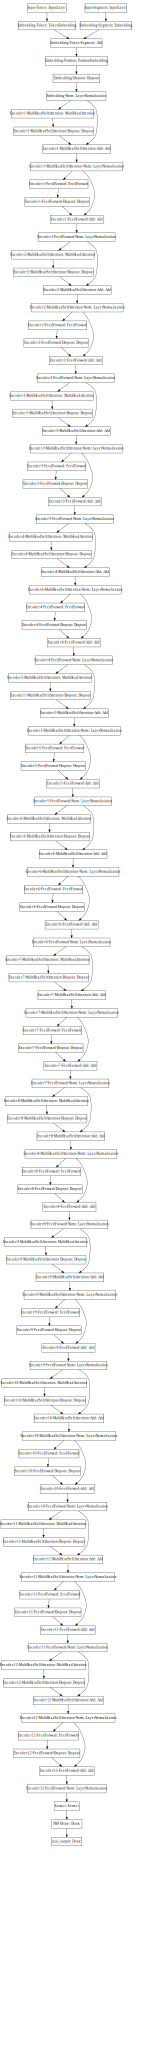

In [43]:
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(get_bert_finetuning_model(model), dpi=65).create(prog='dot', format='svg'))

In [44]:
### 훈련
### 조금 시간이 걸리고 보통 4epoch를 돌려준다. 
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init = tf.variables_initializer([v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables])
sess.run(init)

bert_model = get_bert_finetuning_model(model)
history = bert_model.fit(train_x, train_y1, epochs=2, batch_size=16, verbose = 1, validation_data=(test_x, test_y1), shuffle=True)

Train on 1698 samples, validate on 562 samples
Epoch 1/2
1698/1698 [==============================] - 58s 34ms/step - loss: 0.3109 - acc: 0.8759 - val_loss: 0.2519 - val_acc: 0.9158
Epoch 2/2
1698/1698 [==============================] - 37s 22ms/step - loss: 0.2212 - acc: 0.9292 - val_loss: 0.2453 - val_acc: 0.9158


In [45]:
path  # 재사용을 위해 : bert_model를 지드라이브에 저장.

'gdrive/My Drive/Colab Notebooks/naver_sentiment'

In [0]:
bert_model.save_weights(path+"/bert_naver_score.h5")

In [0]:
### 버트 모형을 로드
bert_model = get_bert_finetuning_model(model)
bert_model.load_weights(path+"/bert_naver_score.h5")

In [0]:
## 테스트 데이터를 버트 모형에 넣도록 predict_convert_data 함수를 정의해준다.
## convert_data함수와 다른 점. test 데이터이기때문에 label은 고려하지 않음.

def predict_convert_data(data_df):
    global tokenizer
    indices = []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        indices.append(ids)
        
    items = indices
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def predict_load_data(x): #Pandas Dataframe을 인풋으로 받는다
    data_df = x
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_x = predict_convert_data(data_df)
    return data_x

In [49]:
test_set = predict_load_data(test)

100%|██████████| 562/562 [00:00<00:00, 5430.58it/s]


In [50]:
type(test_set)

list

In [0]:
### 테스트 셋으로 예측하기 - 예측 시간 5-10분 정도
preds = bert_model.predict(test_set)

In [53]:
print(len(preds))
print(preds[0:10])
pred_max = np.argmax(preds)
pred_max[0:10]

562
[[0.01742417 0.02248541 0.02974178 0.03343931 0.07716588 0.8197434 ]
 [0.01697971 0.02117004 0.03066551 0.03912238 0.08325018 0.8088122 ]
 [0.017385   0.02242798 0.02975946 0.03337389 0.07703485 0.8200188 ]
 [0.01657317 0.02122141 0.02958524 0.03652807 0.07923417 0.816858  ]
 [0.01707896 0.02251131 0.02972539 0.03518441 0.0779222  0.8175777 ]
 [0.01707896 0.02251131 0.02972539 0.03518441 0.0779222  0.8175777 ]
 [0.01707896 0.02251131 0.02972539 0.03518441 0.0779222  0.8175777 ]
 [0.01707896 0.02251131 0.02972539 0.03518441 0.0779222  0.8175777 ]
 [0.01707896 0.02251131 0.02972539 0.03518441 0.0779222  0.8175777 ]
 [0.01664675 0.02140843 0.02965111 0.03568568 0.07879966 0.8178084 ]]


IndexError: ignored

In [0]:
from sklearn.metrics import classification_report

In [0]:
y_true = test['감정판단']
# F1 Score 확인
print(classification_report(y_true, np.round(preds,0)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.89      1.00      0.94       502

    accuracy                           0.89       562
   macro avg       0.45      0.50      0.47       562
weighted avg       0.80      0.89      0.84       562



In [0]:
bert_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

In [0]:
bert_model.input

[<tf.Tensor 'Input-Token:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'Input-Segment:0' shape=(?, 128) dtype=float32>]

In [0]:
bert_model.layers[-2].output

<tf.Tensor 'NSP-Dense/Tanh:0' shape=(?, 768) dtype=float32>

In [0]:
### 마지막 768개의 피쳐를 부분을 잘라낸다.
### 768개의 피쳐를 추출하여 마지막 768개의 값으로 반환
def get_feature_map(model):
  inputs = model.input
  print(inputs)
  outputs = model.layers[-2].output
  print(outputs)
  feature_model = Model(inputs, outputs)
  return feature_model

In [0]:
bert_feature = get_feature_map(bert_model)
print(type(bert_feature))

[<tf.Tensor 'Input-Token:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'Input-Segment:0' shape=(?, 128) dtype=float32>]
Tensor("NSP-Dense/Tanh:0", shape=(?, 768), dtype=float32)
<class 'keras.engine.training.Model'>


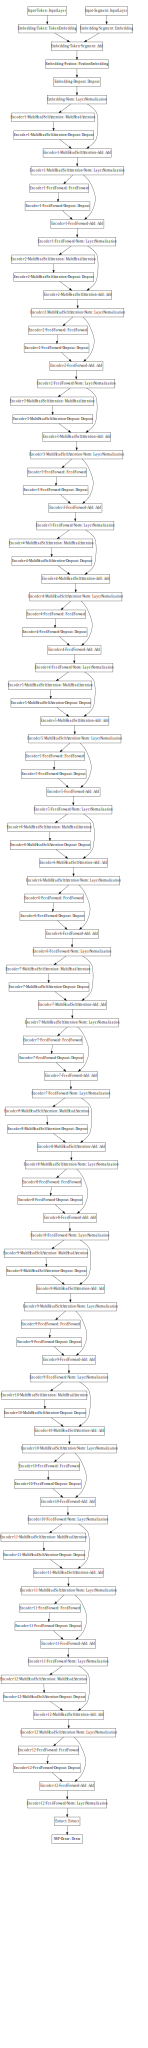

In [0]:
SVG(model_to_dot(bert_feature, dpi=65).create(prog='dot', format='svg'))

In [0]:
bert_weight_list = bert_feature.predict(test_set)

In [0]:
bert_weight_list

array([[ 0.6768613 , -0.34577873, -0.44642594, ..., -0.46659446,
         0.4760487 ,  0.554863  ],
       [ 0.63960963, -0.21447237,  0.3751952 , ..., -0.75756145,
         0.54507357,  0.64565605],
       [ 0.6462688 , -0.22030291,  0.29965237, ..., -0.76921386,
         0.4767284 ,  0.5631936 ],
       ...,
       [ 0.6250664 , -0.18705241, -0.0571351 , ..., -0.67899805,
         0.45182475,  0.4458032 ],
       [-0.75391245,  0.4165041 ,  0.3838565 , ...,  0.37433255,
        -0.4284077 , -0.4931942 ],
       [ 0.418387  ,  0.01214304,  0.23017944, ..., -0.6176592 ,
         0.23473784,  0.35688388]], dtype=float32)

In [0]:
labels = test['label']

In [0]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [0]:
## PCA를 사용하여 256차원으로 줄임.
### TSNE알고리즘을 이용하여 3차원으로 축소
bert_embedded = PCA(n_components=256).fit_transform(bert_weight_list)
bert_embedded = TSNE(n_components=3).fit_transform(bert_embedded)
bert_embedded

array([[  8.1150055 ,  -8.874124  , -16.434155  ],
       [ -0.72656894,  -9.172297  ,  -0.82666355],
       [  4.0125003 , -10.47917   ,   7.4953313 ],
       ...,
       [ 13.100047  ,  -2.0513175 ,   7.7851586 ],
       [-15.717123  ,  -1.3705051 ,   5.6138134 ],
       [ 17.13837   , -10.026363  ,  -2.8951561 ]], dtype=float32)

In [0]:
path

'gdrive/My Drive/Colab Notebooks/naver_sentiment'

In [0]:
## 추후 임베딩을 위해 pickle모듈을 저장해 주기 
with open(path+"/bertembedding.pkl", "wb") as f:
  pickle.dump(bert_embedded, f)

In [0]:
## 임베딩 로드
with open(path+"/bertembedding.pkl", "rb") as f:
  bert_embedded = pickle.load(f)

In [0]:
## 3D을 그리기 위해 matplotlib 모듈을 로드
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import seaborn as sns

In [0]:
test

id                                           document  label
0      6270596                                                굳 ㅋ      1
1      9274899                               GDNTOPCLASSINTHECLUB      0
2      8544678             뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3      6825595                   지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0
4      6723715  3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??      0
...        ...                                                ...    ...
49995  4608761          오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함      1
49996  5308387       의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO      0
49997  9072549                 그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다      0
49998  5802125     절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네      0
49999  6070594                                         마무리는 또 왜이래      0

[50000 rows x 3 columns]

In [0]:
def get_tsne_plot(rot1=-20, rot2=100):
  fig = plt.figure(figsize=(5,5))
  ax = Axes3D(fig)
  colors = 'b', 'r'
  labels = 0, 1
  for i, c, label in zip(range(np.shape(bert_embedded)[0]), colors, labels):
    ax.scatter(bert_embedded[test['label']==label,0], bert_embedded[test['label']==label,1], bert_embedded[test['label']==label,2], s=2, c=c, alpha=0.5)
  ax.view_init(rot1, rot2)
  print("rot1:%d" % rot1, "rot2:%d" % rot2)
  plt.legend(labels, loc='upper right')
  plt.show()

rot1:-180 rot2:-180


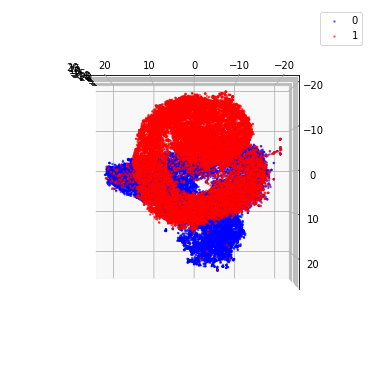

rot1:-135 rot2:-180


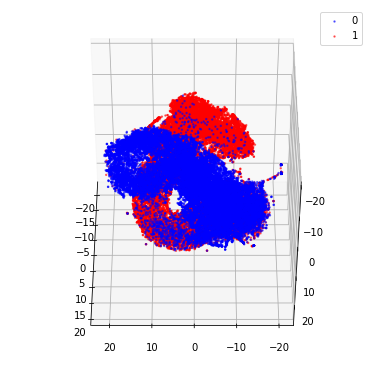

rot1:-90 rot2:-180


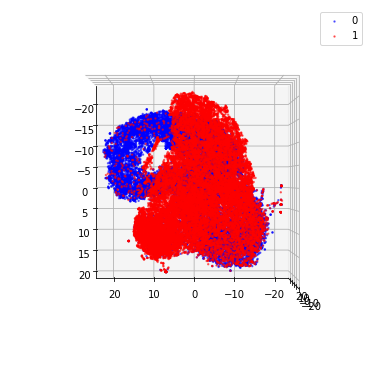

rot1:-45 rot2:-180


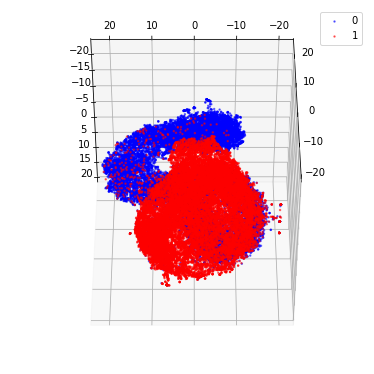

rot1:0 rot2:-180


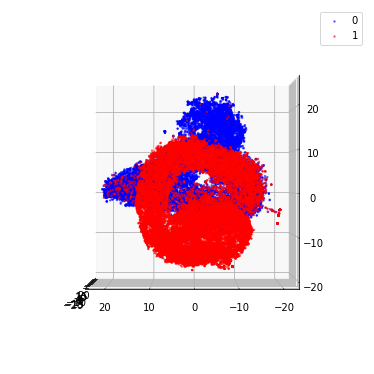

rot1:45 rot2:-180


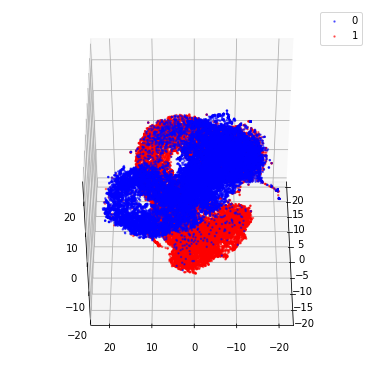

rot1:90 rot2:-180


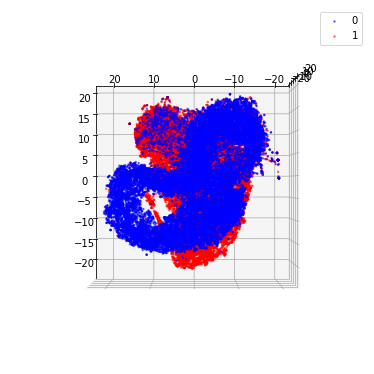

rot1:135 rot2:-180


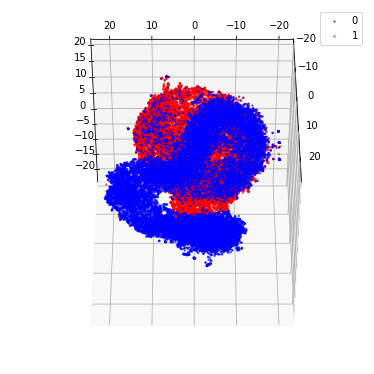

rot1:-180 rot2:-135


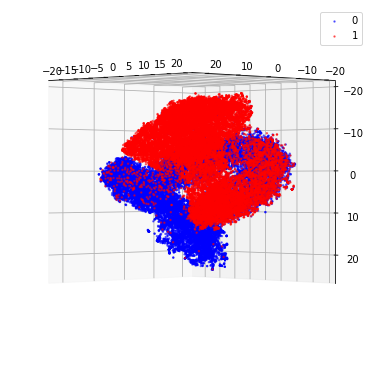

rot1:-135 rot2:-135


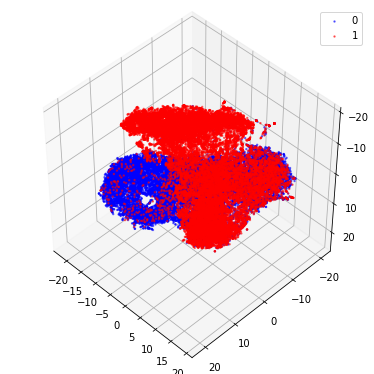

rot1:-90 rot2:-135


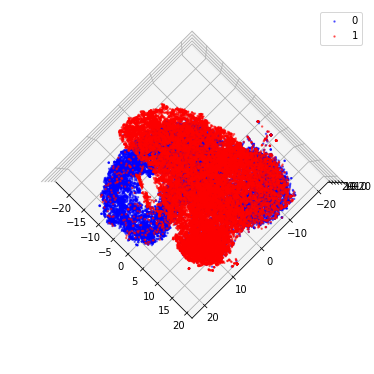

rot1:-45 rot2:-135


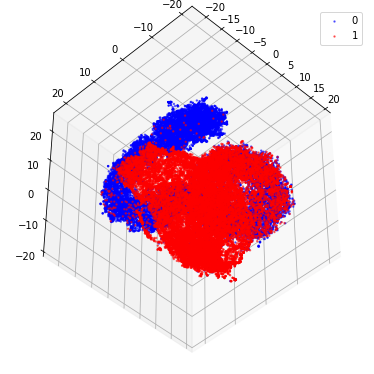

rot1:0 rot2:-135


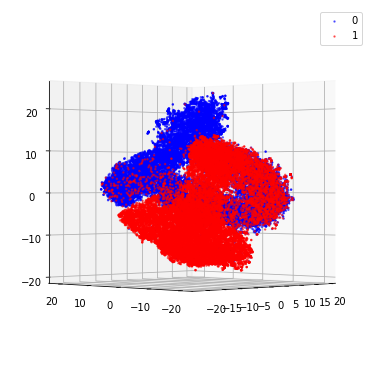

rot1:45 rot2:-135


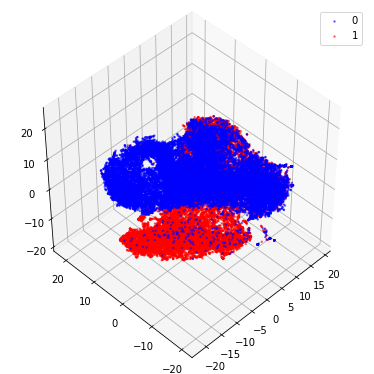

rot1:90 rot2:-135


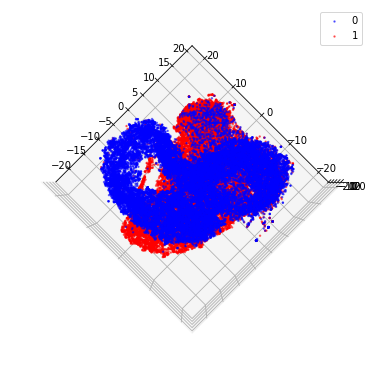

rot1:135 rot2:-135


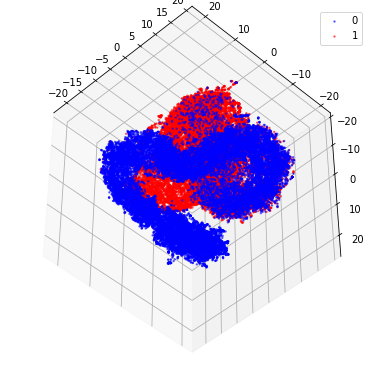

rot1:-180 rot2:-90


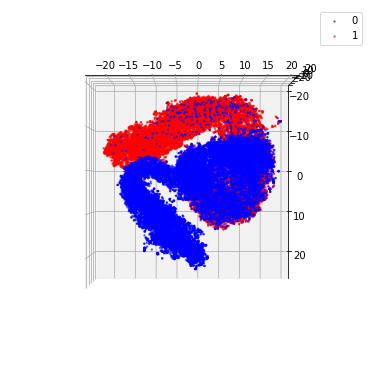

rot1:-135 rot2:-90


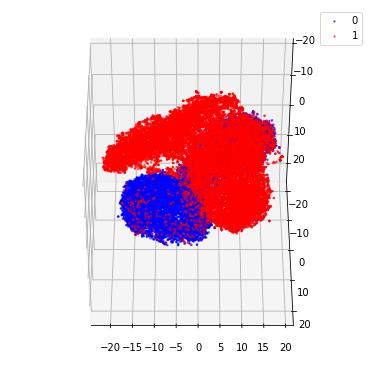

rot1:-90 rot2:-90


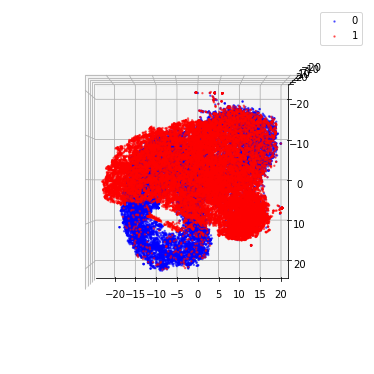

rot1:-45 rot2:-90


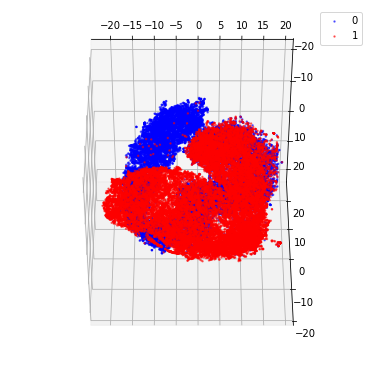

rot1:0 rot2:-90


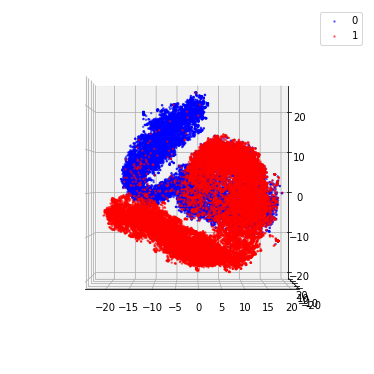

rot1:45 rot2:-90


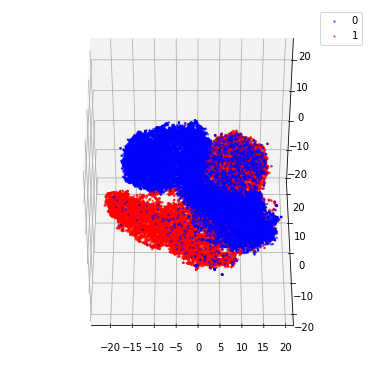

rot1:90 rot2:-90


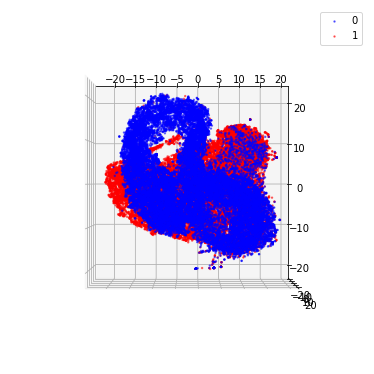

rot1:135 rot2:-90


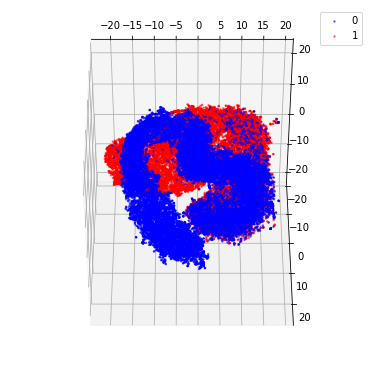

rot1:-180 rot2:-45


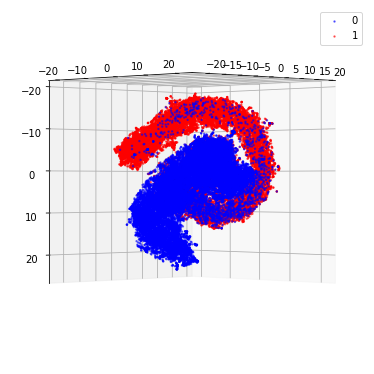

rot1:-135 rot2:-45


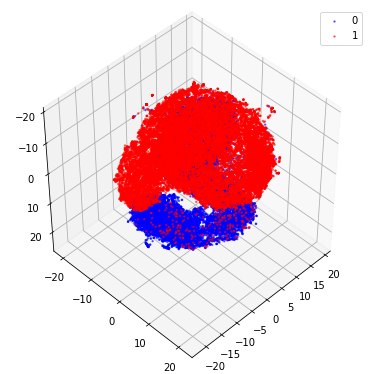

rot1:-90 rot2:-45


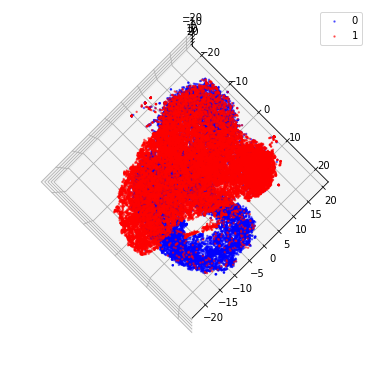

rot1:-45 rot2:-45


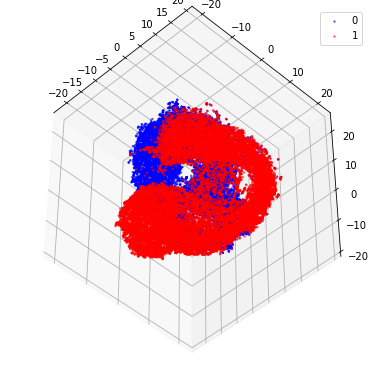

rot1:0 rot2:-45


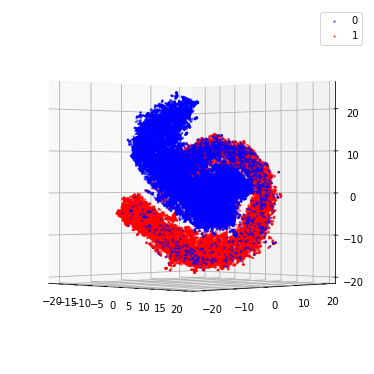

rot1:45 rot2:-45


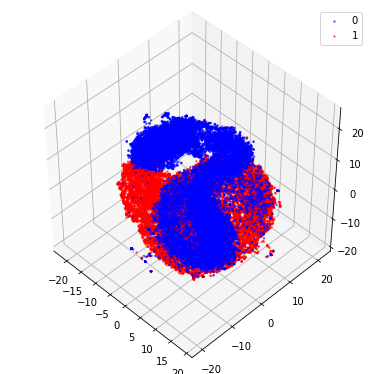

rot1:90 rot2:-45


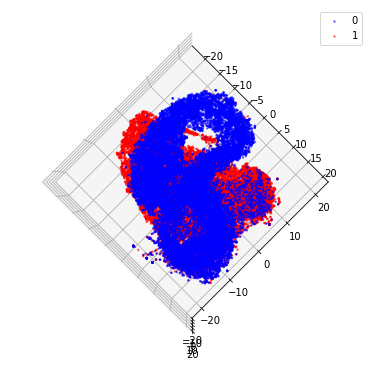

rot1:135 rot2:-45


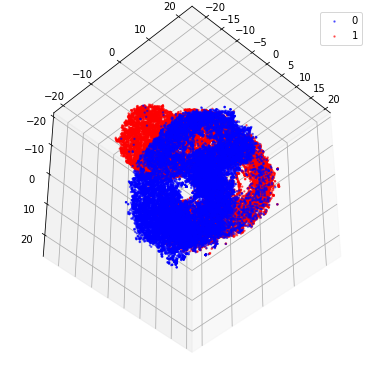

rot1:-180 rot2:0


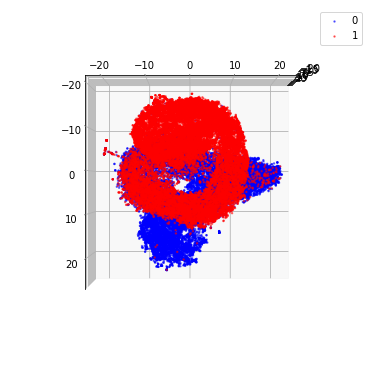

rot1:-135 rot2:0


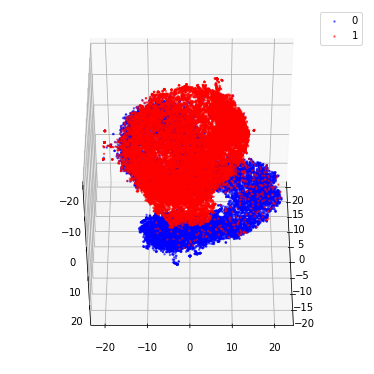

rot1:-90 rot2:0


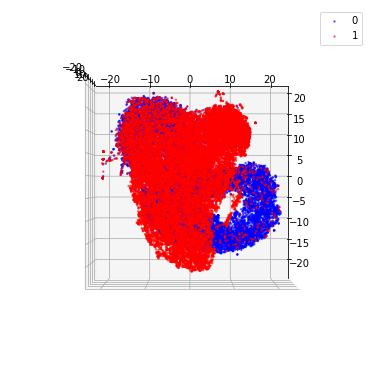

rot1:-45 rot2:0


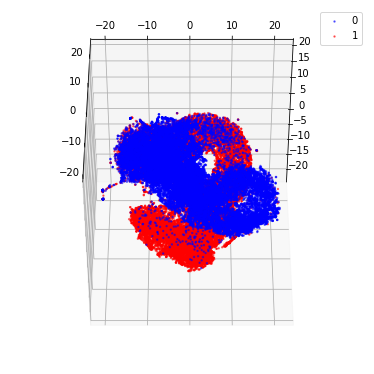

rot1:0 rot2:0


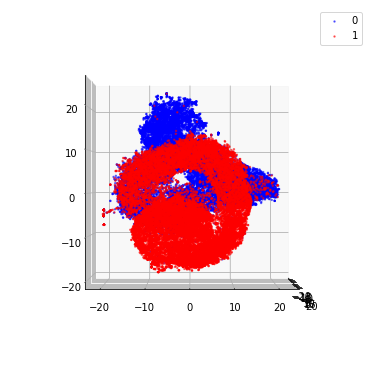

rot1:45 rot2:0


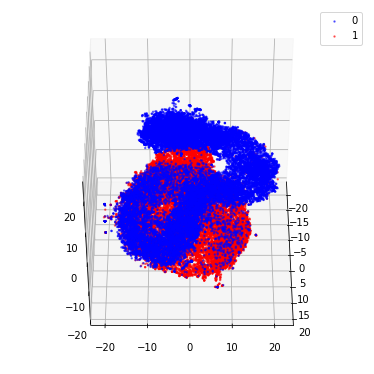

rot1:90 rot2:0


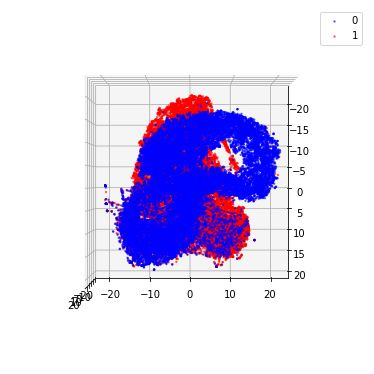

rot1:135 rot2:0


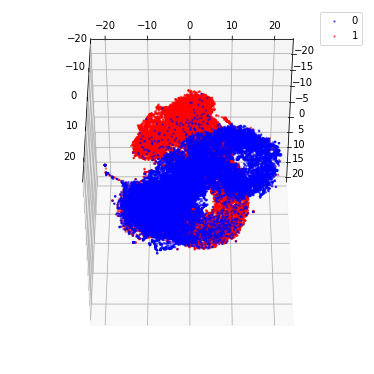

rot1:-180 rot2:45


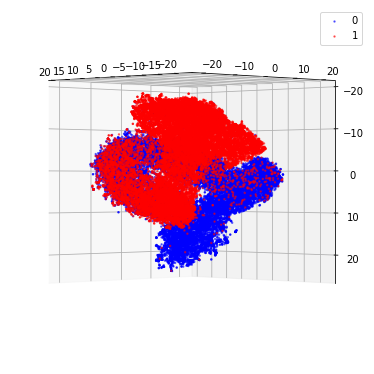

rot1:-135 rot2:45


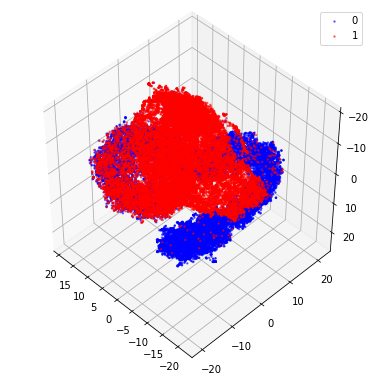

rot1:-90 rot2:45


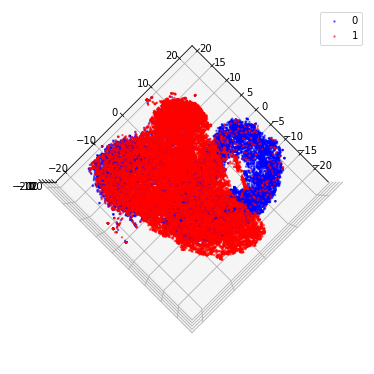

rot1:-45 rot2:45


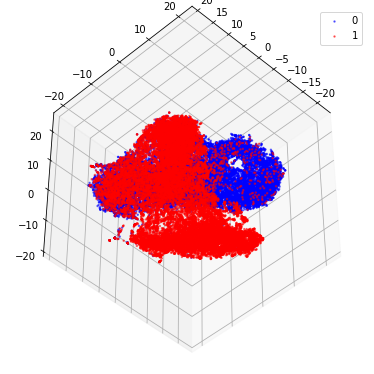

rot1:0 rot2:45


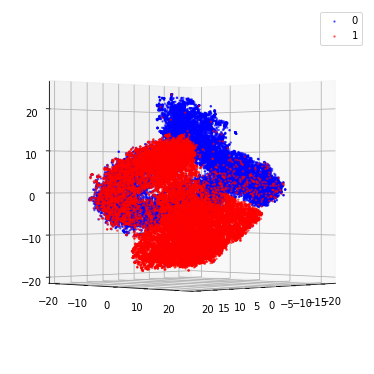

rot1:45 rot2:45


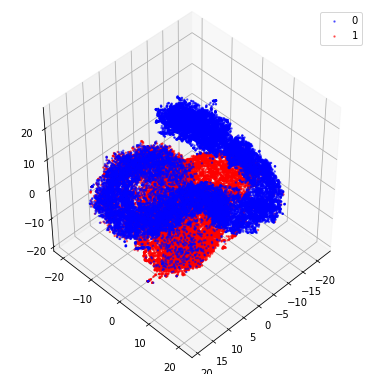

rot1:90 rot2:45


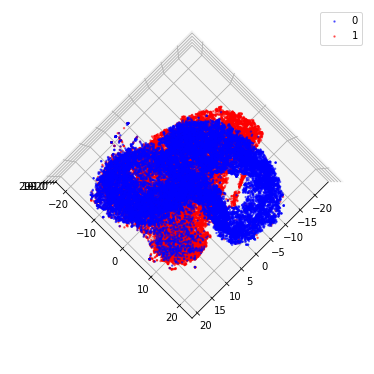

rot1:135 rot2:45


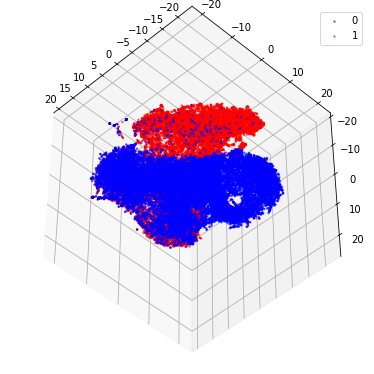

rot1:-180 rot2:90


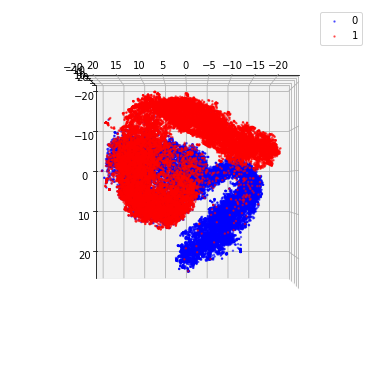

rot1:-135 rot2:90


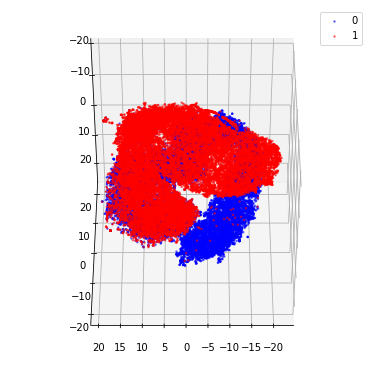

rot1:-90 rot2:90


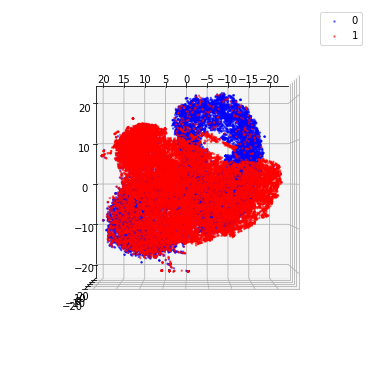

rot1:-45 rot2:90


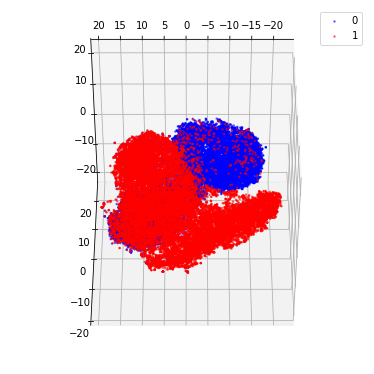

rot1:0 rot2:90


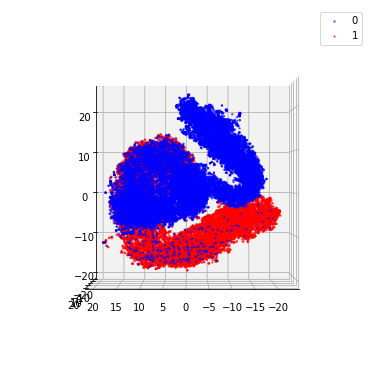

rot1:45 rot2:90


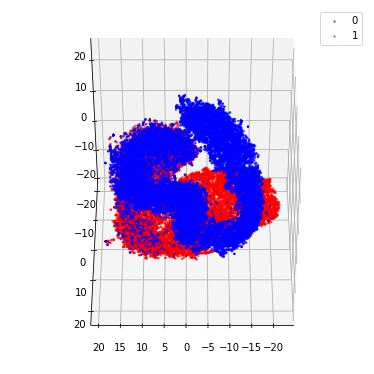

rot1:90 rot2:90


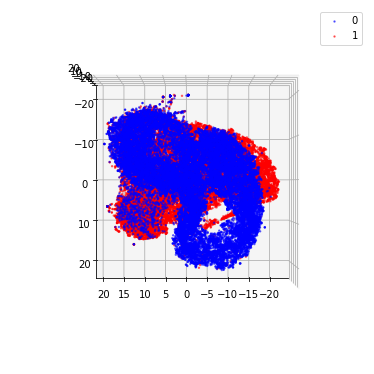

rot1:135 rot2:90


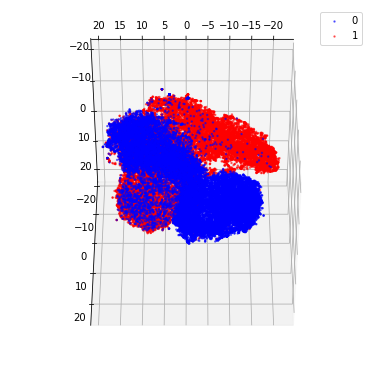

rot1:-180 rot2:135


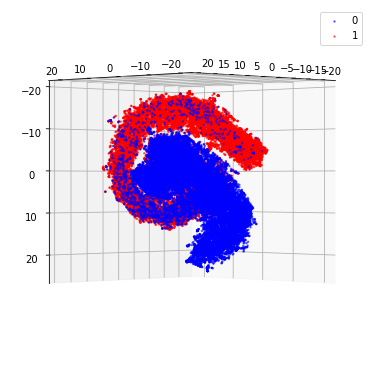

rot1:-135 rot2:135


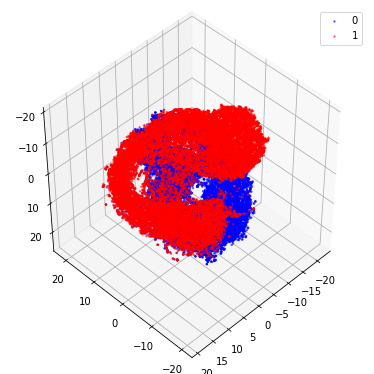

rot1:-90 rot2:135


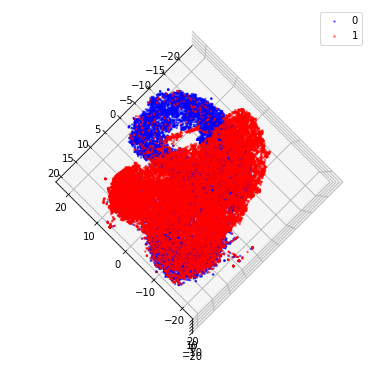

rot1:-45 rot2:135


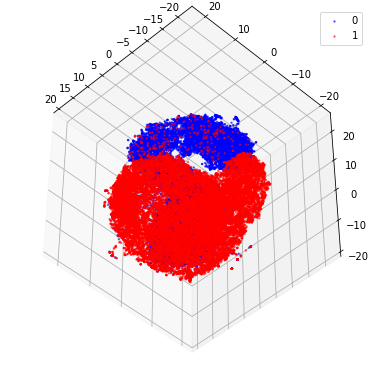

rot1:0 rot2:135


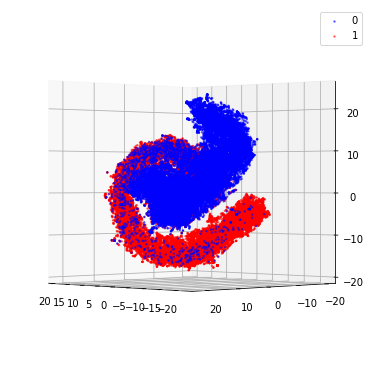

rot1:45 rot2:135


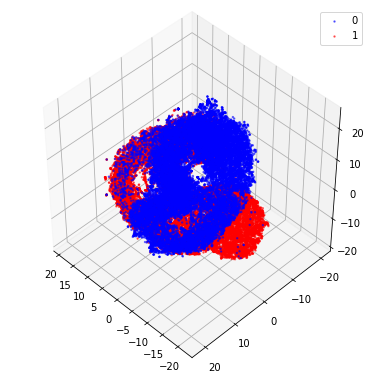

rot1:90 rot2:135


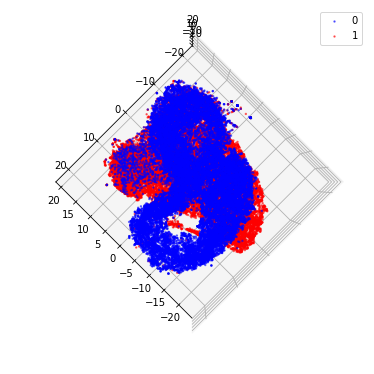

rot1:135 rot2:135


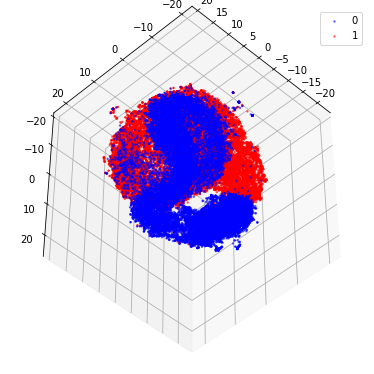

In [0]:
import time
for j in range(-180, 180, 45):
  for i in range(-180,180,45):
    get_tsne_plot(i, j)
